In [66]:
using ONNXNaiveNASflux
using Random
using Flux, Statistics, ProgressMeter, Plots, TaijaData, Distances, MLDatasets, CSV, DataFrames
using Flux: onehotbatch, onecold, crossentropy, logitcrossentropy, mse, throttle, update!, push!

### Loading up our saved models

In [67]:
adv_pgd_strong = ONNXNaiveNASflux.load("../models/adv_pgd_strong.onnx")
adv_pgd_medium = ONNXNaiveNASflux.load("../models/adv_pgd_medium.onnx")
adv_pgd_weak = ONNXNaiveNASflux.load("../models/adv_pgd_weak.onnx")
model = ONNXNaiveNASflux.load("../models/classically_trained.onnx")

CompGraph with graphsummary:
┌────────────────┬───────────┬────────────────┬─────────────────────────┐
│ Graph Position │ Vertex Nr │ Input Vertices │ Op                      │
├────────────────┼───────────┼────────────────┼─────────────────────────┤
│ Input          │ 1         │                │                         │
│ Hidden         │ 2         │ 1              │ Dense(784 => 128, relu) │
│ Output         │ 3         │ 2              │ Dense(128 => 10)        │
└────────────────┴───────────┴────────────────┴─────────────────────────┘


### Loading up our MNIST data

In [68]:
train_df = CSV.read("../data/mnist_train.csv", DataFrame; header=false)
train_data = Matrix(train_df)

test_df = CSV.read("../data/mnist_test.csv", DataFrame; header=false)
test_data = Matrix(test_df)

x_train = train_data[:, 2:785]' ./ 255
y_train = train_data[:, 1]

x_test = test_data[:, 2:785]' ./ 255
y_test = test_data[:, 1]

x_train

784×60000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

### Preparing models for Counterfactual generation

In [69]:
using CounterfactualExplanations

flux_clean = CounterfactualExplanations.MLP(model; likelihood=:classification_multi)
flux_adv_strong = CounterfactualExplanations.MLP(adv_pgd_strong; likelihood=:classification_multi)
flux_adv_medium = CounterfactualExplanations.MLP(adv_pgd_medium; likelihood=:classification_multi) 
flux_adv_weak = CounterfactualExplanations.MLP(adv_pgd_weak; likelihood=:classification_multi)

CounterfactualExplanations.Models.Model(CompGraph(3 vertices), :classification_multi, CounterfactualExplanations.Models.Fitresult(CompGraph(3 vertices), Dict{Any, Any}()), MLP())

### Plot random counterfactuals

In [5]:
counterfactual_data = CounterfactualData(x_train, y_train)
counterfactual_data.domain = [(0, 1) for var in counterfactual_data.features_continuous]
generator = CounterfactualExplanations.ECCoGenerator(; λ=[0.01, 0.1])
convergence = CounterfactualExplanations.GeneratorConditionsConvergence(decision_threshold=0.7, max_iter=1000)

CounterfactualExplanations.Convergence.GeneratorConditionsConvergence(0.7, 0.01, 1000, 0.75)

CounterfactualExplanation
Convergence: ❌ after 1000 steps.
image = [0.0, 0.0, 2.8196112862133307e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001926719298353419, 0.0003155409169266932, 0.0, 7.07615690316743e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00012243101709827898, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003461316850007279, 0.0, 0.23081962402388292, 0.0004974872179445811, 0.7799423301949202, 0.39930371756846317, 0.0, 0.0008304941098563405, 0.00030025915402802643, 0.2671136955735161, 0.4479166886990838, 0.4741017845200706, 0.6271294459681475, 0.00031788497164961883, 0.08587984715724781, 0.000649309711297974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20424534473297015, 0.12499592574021548, 0.12029182319458467, 0.1786983373814285, 0.8554574308908952, 0.7325200530529224, 0.4588616188376164, 0.7355476924500193, 0.20933514673215023, 0.6195959204022873, 1.0, 0.6030333855216952, 0.0, 0.0, 0.0, 0.6344173015350569, 0.4046714830247027, 0.2734846864072196, 0.99999

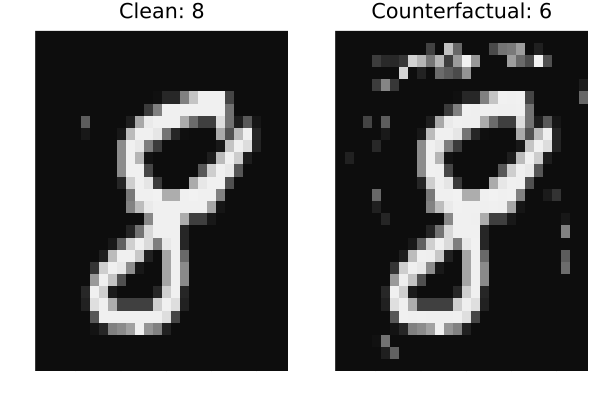

In [63]:
include("../utils/plot.jl")

using CounterfactualExplanations.Evaluation: evaluate, validity

model_to_use = flux_clean
# model_to_use = flux_adv_strong
# model_to_use = flux_adv_medium
# model_to_use = flux_adv_weak

# random point's Counterfactual
index = rand(1:10000)

different_label = rand(0:8)
if different_label >= y_test[index]
    different_label += 1
end
 
ce = generate_counterfactual(
        reshape(x_test[:, index], 784, 1), different_label, counterfactual_data, model_to_use, generator; num_counterfactuals=1, convergence=convergence
    )

println(ce)

ces = CounterfactualExplanations.counterfactual(ce)
cfimage = ces[:, 1]
println("image = ", cfimage)
println("correct_class = ", ce.target)
println("also should be same: ", different_label)

inf_model = model
# inf_model = adv_pgd_strong
# inf_model = adv_pgd_medium
# inf_model = adv_pgd_weak

cf_pred = (inf_model(cfimage) |> Flux.onecold |> getindex) - 1
println("valid? ", evaluate(ce; measure=validity)[1][1])
actualimage = x_test[:, index]
actual_pred = (inf_model(actualimage) |> Flux.onecold |> getindex) - 1
plot_normal_and_ce(actualimage, actual_pred, cfimage, cf_pred, y_test[index])

### Experimental Setup

In [70]:
Random.seed!(42)

function generate_split(num_datapoints)
    rand(1:num_datapoints, 200)
end

function random_excluding(exclude)
    value = rand(0:8)
    return value < exclude ? value : value + 1
end

split = generate_split(length(y_test))
targets = [random_excluding(y_test[num]) for num in split]

split
# splits = [generate_split(length(y_test)) for _ in 1:5]
# targets = [[random_excluding(y_test[num]) for num in split] for split in splits]

200-element Vector{Int64}:
 6294
 4504
 4775
 7032
 6734
 1659
 6135
 6684
 4571
 2994
    ⋮
 1434
   43
 4846
 3319
 7232
 1186
 2053
 9077
 4493

#### Experiment: Clean Model

In [11]:
using CounterfactualExplanations

model_to_use = model
counterfactuals = []

for (j, index) in enumerate(split)
    
    model_pred = (model_to_use(x_test[:, index]) |> Flux.onecold |> getindex) - 1
    if model_pred != y_test[index]
        println("skipping since the model misclassified this point")
        continue
    end

    if (j % 10 == 0)
        println("reached datapoint ", j)
    end

    ce = generate_counterfactual(
        reshape(x_test'[index, :], 784, 1), targets[j], counterfactual_data, flux_clean, generator; num_counterfactuals=1, convergence=convergence
    )

    ce_datapoint = CounterfactualExplanations.counterfactual(ce)[:, 1]
    push!(ce_datapoint, targets[j])

    if j == 1
        print("counterfactual instance: ", ce_datapoint)
    end

    # print("counterfactual instance: ", ce_datapoint)
    push!(counterfactuals, ce_datapoint)
end

counterfactuals

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(784 => 128, relu)
│   summary(x) = 784-element Vector{Float64}
└ @ Flux /root/.julia/packages/Flux/97jpP/src/layers/stateless.jl:59


counterfactual instance: [0.0, 0.0, 0.0, 5.7624500004749284e-5, 0.00012153342504461762, 0.0, 0.0, 0.0, 2.8151048354629893e-5, 0.0, 1.2070123784724275e-5, 0.0, 0.0, 0.0, 0.0, 0.00013697097019758076, 0.0, 0.0, 0.0, 0.0, 7.560561316495297e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 8.461301886200091e-5, 4.0047571565082764e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.067849333499908e-5, 0.0, 0.0, 0.0002802821582008619, 0.0, 2.4606785154901447e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003688425491418457, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025511331186862664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00014938519764109515, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.781561435971526e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06291284740376808, 0.4264516683742396, 0.4314672899407433, 0.30483338172

196-element Vector{Any}:
 [0.0, 0.0, 0.0, 5.7624500004749284e-5, 0.00012153342504461762, 0.0, 0.0, 0.0, 2.8151048354629893e-5, 0.0  …  0.00011378985545889009, 0.000537484438973479, 0.7421172705597336, 0.9432954472546259, 0.538145509762815, 0.0, 0.0, 7.005674187894328e-5, 1.1909031991308439e-5, 7.0]
 [0.00011472191365555773, 9.199987766805862e-6, 0.0, 0.0, 7.440498416144692e-5, 1.1309604872167256e-5, 0.0, 0.0, 0.0, 0.0  …  0.00021384738170127093, 0.0, 0.0, 3.924415450455854e-5, 0.0, 0.0, 0.0, 1.0300297481080635e-5, 4.822963023798366e-6, 8.0]
 [0.0, 2.352156532197114e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010071669803437545, 0.0  …  0.0, 0.0005844307081133593, 0.1733732782820025, 0.08782367113508951, 0.00015221886189829094, 0.0, 0.0, 0.0, 0.0, 7.0]
 [0.0, 0.0, 0.0, 6.409057044720612e-5, 3.2488325359736336e-5, 0.0, 9.036216238200724e-6, 0.0, 5.961647000276571e-5, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.372101208100504e-5, 8.0]
 [0.0, 0.0, 0.0, 4.6103926115392825e-5, 0.0, 0.0, 0.0

In [12]:
using DataFrames
using CSV

df = DataFrame(mapreduce(permutedims, vcat, counterfactuals), :auto)
CSV.write("data.csv", df)

df

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0.0,0.0,0.0,5.76245e-5,0.000121533,0.0,0.0,0.0,2.8151e-5,0.0,1.20701e-5,0.0,0.0,0.0,0.0,0.000136971,0.0,0.0,0.0,0.0,7.56056e-5,0.0,0.0,0.0,0.0,0.0,8.4613e-5,4.00476e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.06785e-5,0.0,0.0,0.000280282,0.0,2.46068e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000368843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000255113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
2,0.000114722,9.19999e-6,0.0,0.0,7.4405e-5,1.13096e-5,0.0,0.0,0.0,0.0,0.000118431,0.0,1.6989e-5,0.0,0.0,0.0,0.0,7.4934e-6,0.0,0.0,0.0,1.5803e-5,0.0,0.0,0.0,0.0,0.0,1.04363e-5,8.42664e-5,8.46346e-5,0.0,7.20749e-5,0.0,0.0,0.000117956,5.84124e-5,0.0,0.0,0.000238788,0.0,0.000139709,0.000292323,0.000477097,0.000548319,0.0,0.0,0.000287915,0.000349924,0.000588486,0.0,0.0,0.0,0.0,0.0,0.0,4.30353e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.000150929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000384311,0.246185,0.537198,0.0,0.0,0.0,0.000276198,5.95507e-6,0.0,0.0,0.0,3.17135e-5,0.0,0.000104632,0.0,0.0,0.0,0.0,0.0,0.0,0.000532374,0.0,0.0281397,0.0,0.0,0.0,0.0,0.000107966,⋯
3,0.0,2.35216e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.000100717,0.0,0.0,0.0,0.0,0.0,0.0,0.000189165,0.0,0.0,4.45582e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6734e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.96696e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.74899e-6,0.0,0.0,0.0,0.0,0.0,2.0868e-5,0.000216171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.45534e-5,0.0,0.0,0.0001188,2.9234e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯
4,0.0,0.0,0.0,6.40906e-5,3.24883e-5,0.0,9.03622e-6,0.0,5.96165e-5,0.0,0.0,0.0,2.27439e-5,2.25948e-5,0.0,3.0996e-5,0.0,0.000150016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.9949e-6,0.0,4.92203e-5,8.19922e-5,0.0,1.34251e-5,0.00012056,7.28351e-5,1.11817e-5,4.23864e-5,0.0,0.0,0.0,0.0,0.00015466,2.4365e-5,1.74218e-5,0.000272116,0.000272659,0.0,0.0,0.000187824,7.73275e-5,0.0,4.0414e-5,0.0,0.0,0.0,0.0,5.87446e-5,0.000105381,0.0,0.000157733,0.000194582,0.000114615,0.000287517,0.0,0.000277778,0.000701798,0.0,0.0,0.0,0.0,0.0,7.34211e-5,0.0,0.0,0.0,0.000243761,0.0,8.01098e-5,0.0,8.16568e-5,0.0,0.0,0.00010755,0.0,0.0,0.0,0.00880337,0.000205635,0.166579,0.000500669,0.328868,0.0,0.0,0.0,0.0,0.0,0.0,9.31261e-5,⋯
5,0.0,0.0,0.0,4.61039e-5,0.0,0.0,0.0,0.0,0.0,6.80545e-5,0.0,0.0,0.0,0.0,0.0,0.0,4.93159e-6,0.0,0.0,0.0,7.3439e-5,0.0,0.0,2.46301e-6,0.000112877,0.0,3.20677e-5,0.0,0.0,0.0,6.7383e-5,0.0,0.0,5.91716e-5,0.0,0.0,0.0,6.5423e-5,0.000103766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000124236,0.0,3.17822e-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.54487e-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000119846,0.000247097,0.0,0.0,0.0,0.0,2.53088e-5,2.